<a href="https://colab.research.google.com/github/arjunsumina/analytics_code/blob/main/twitter_analysis_data_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

df = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Data/TWITTER_DATA/training.1600000.processed.noemoticon.csv',encoding="ISO-8859-1",
  usecols=[0, 5],
  names=['target', 'text'],
  engine='python',
  error_bad_lines=False,)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:>

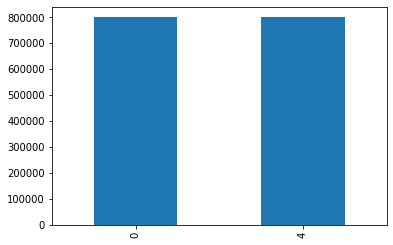

In [5]:
df['target'].value_counts().plot(kind='bar')

In [6]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# Pre-processing
remove all urls and user mentions, hashtags,
accept only letters and digits
remove extra spaces
parse everything to lowercase
rename target class 4 -> 1

In [7]:
df['text'] = df['text'] \
	.str.replace(r'(?:@|#|https?:|www\.)\S+', '') \
	.str.replace(r'[^A-Za-z0-9 ]+', '') \
	.str.split() \
	.str.join(' ') \
	.str.lower()

df['target'] = df['target'].replace(4, 1)

<ipython-input-7-860eb343819f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'] \




cleaned data



In [8]:
df.head()

,target,text
0,0,awww thats a bummer you shoulda got david carr...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


train and test set creation
With random_state=None , we get different train and test sets across different executions and the shuffling process is out of control.

With random_state=0 , we get the same train and test sets across different executions. With random_state=42, we get the same train and test sets across different executions, but in this time, the train and test sets are different from the previous case with random_state=0 .

In [9]:
from sklearn.model_selection import train_test_split

TEST_SIZE = .1
RANDOM_STATE = 123

def split_data(test_size: float = TEST_SIZE, random_state: int = RANDOM_STATE):
  X = df['text']
  y = df['target']

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                      random_state=random_state,
                                                      stratify=y)
  return X_train, X_test, y_train, y_test

I will implement it using CountVectorizer from sklearn which converts a collection of text documents to a matrix of token counts. This approach will then enable us to use preprocessed vectors as an input for the LogisticRegression model.The first model that will be checked is a so-called Bag of words model. The bag-of-words model is a simplifying representation used in NLP

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

NGRAM_RANGE = 2
MAX_ITER = 1000

X_train, X_test, y_train, y_test = split_data(TEST_SIZE,RANDOM_STATE)

vectorizer = CountVectorizer(ngram_range=(1, NGRAM_RANGE))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

log_reg = LogisticRegression(max_iter=MAX_ITER, random_state=RANDOM_STATE)
log_reg = log_reg.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


to see the confusion matrix to understand the prediction accuracy

In [25]:

#print(classification_report(log_reg.predict(X_train), y_train))
#print(classification_report(log_reg.predict(X_test), y_test))

#plot_confusion_matrix(log_reg, X_train, y_train)
#plot_confusion_matrix(log_reg, X_test, y_test)

from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = log_reg.predict(X_test)
confusion_matrix(y_true, y_pred)




array([[685085,  34915],
       [ 31168, 688832]])

In [26]:
from sklearn.metrics import confusion_matrix
y_true = y_train
y_pred = log_reg.predict(X_train)
confusion_matrix(y_true, y_pred)


array([[685085,  34915],
       [ 31168, 688832]])

how to understand the pair of words that have a positive influence and pair of words that have a negative influence

In [22]:
print(vectorizer)

CountVectorizer(ngram_range=(1, 2))


In [24]:
import numpy as np

top_n = 10

features = vectorizer.get_feature_names_out() 

# get features with lowest coeficients
positive = np.argsort(log_reg.coef_[0])[::-1][:top_n]

# get features with heighest coeficients
negative = np.argsort(log_reg.coef_[0])[:top_n]

print(f'\n Positive features: \n {[features[x] for x in positive]}')
print(f'\n Negative features: \n {[features[x] for x in negative]}')




 Positive features: 
 ['not sad', 'no problem', 'doesnt hurt', 'not bad', 'no problems', 'no prob', 'not problem', 'never too', 'no probs', 'cant miss']

 Negative features: 
 ['clean me', 'not happy', 'sad', 'passed away', 'rip', 'not looking', 'funeral', 'headache', 'disappointing', 'upsetting']
